In [1]:
# Dependence of Sumbarine Melt (Qsm) on Temp and Strat
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
### Variables for scaling Qsm
Qsg = 250 # Subglacial discharge
N = 20 # Number of data points
# Thermal forcing
T0 = 0 # Freezing temp of seawater
Tice = np.linspace(0, 12, N)
TF = Tice - T0

# Stratification
Rhoz = np.linspace(5, 10, N) # Depth averaged density gradient
#Strat1 = np.sqrt(Rhoz)
Nsquare = np.linspace(2e-5, 3e-4, N) # Buoyancy frequency
#Strat2 = (Nsquare)**(5/8)

# Submarine melt
[Rhoz_mesh, TF_mesh1] = np.meshgrid(Rhoz, TF)
Qsm1 = TF_mesh1 / np.sqrt(Rhoz_mesh) # Scaling by (Magorrian & Wells, 2016)

[N2_mesh, TF_mesh2] = np.meshgrid(Nsquare, TF)
Qsm2 = TF_mesh2 / ((N2_mesh)**(5/8)) # Scaling by (Slater et al., 2016)

In [3]:
#np.linspace(3e-5, 3e-4, 15)
#Qsm2/Qsg

In [3]:
# Obtain submarine melting Qsm
def IFA(datapath, case_id):
    # Grid areas
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200
    file0 = xr.open_dataset(datapath+'/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    file = file0.isel(T=~file0.get_index("T").duplicated()) 
    t0 = 89
    tn = len(file.T)
    state = file.isel(Y=range(35,45), T=range(t0,tn))
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [4]:
def Qsm_depend(datapath, case_id):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(1,len(State.T)))
    
    depth = state.Z.data
    time = state.T.data / 86400 # Time in days
    
    xid = 1
    # Potential temp
    Ttz = state.Temp.data[:,:,:,xid].mean(2) # Temp

    # Pressure and Density
    pres = gsw.p_from_z(depth, 55)
    Stz = state.S.data[:,:,:,xid].mean(2)
    p = np.tile(pres,[len(time),1])
    Rho = gsw.rho(Stz, Ttz, p)
    
    N2, Pmid = gsw.Nsquared(Stz,Ttz,pres,55,axis=1)
    
    
    # Grid areas    
    Area = np.empty(90)
    Area[:20] = 400
    Area[20:50] = 800
    Area[50:] = 1200

    file0 = xr.open_dataset(datapath + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    ip_state = file.isel(Y=range(35,45))
    
    MR = ip_state.icefrntA.isel(X=1).data.mean(2) # Melt rate at the icefront
    Qsm = (MR*Area*10) / (24*3600)
    
    return Ttz, N2

In [5]:
# Compare shallow- and no-sill cases
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_nosill'

case = np.array([1,2,3,4,5])
T_ss = np.ones(len(case)) * np.nan
N2_ss = np.ones(len(case)) * np.nan
T_ns = np.ones(len(case)) * np.nan
N2_ns = np.ones(len(case)) * np.nan

ti, zi = 89, -10
for i in range(len(case)):
    T1, N1 = Qsm_depend(path1, case[i])
    #T_ss[i] = T1[]
    
    T2, N2 = Qsm_depend(path2, case[i])
    N2_ns[i] = N2[ti:,:zi].mean()
    #N2_ss[i] = N1[ti:,:zi].mean()
    #T_ns[i] = T2[]
    if i < 2:
        N2_ss[i] = N1[ti:,:zi].mean() # Shallow-sill values are sensitive to zi
        #N2_ns[i] = N2[ti:,:zi].mean()
    else:
        N2_ss[i] = N1[ti:,:].mean()
        #N2_ns[i] = N2[ti:,:].mean()

# Various inital temp cases (hs/hf=0.08)
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/3_T0_maxQsg'
path4 = '/work/oceans/wbao/MITgcm_results/iceplume/3_T0_minQsg'
maxQsg, minQsg = 500, 50

T_maxq = np.ones(len(case)) * np.nan
N2_maxq = np.ones(len(case)) * np.nan
T_minq = np.ones(len(case)) * np.nan
N2_minq = np.ones(len(case)) * np.nan

Qsm_maxq = np.ones(len(case)) * np.nan
Qsm_minq = np.ones(len(case)) * np.nan

for i in range(len(case)):
    T3, N3 = Qsm_depend(path3, case[i])
    T_maxq[i] = T3[ti:,:zi].mean()
    N2_maxq[i] = N3[ti:,:zi].mean()
    
    T4, N4 = Qsm_depend(path4, case[i])
    T_minq[i] = T4[ti:,:zi].mean()
    N2_minq[i] = N4[ti:,:zi].mean()

    Qsm_maxq[i] = IFA(path3, case[i])
    Qsm_minq[i] = IFA(path4, case[i])


In [6]:
N2_ss, N2_ns, N2_maxq, N2_minq

(array([2.43774989e-04, 1.18638056e-04, 1.03331481e-04, 7.47965535e-05,
        5.89488814e-05]),
 array([2.84687219e-04, 2.12490380e-04, 1.39553863e-04, 6.77439676e-05,
        3.66282854e-05]),
 array([6.88484526e-05, 6.80985266e-05, 6.70989103e-05, 6.58644677e-05,
        6.26739949e-05]),
 array([3.11819365e-05, 3.08988716e-05, 3.05855586e-05, 3.02573517e-05,
        2.97073144e-05]))

In [7]:
Qsm_maxq, Qsm_minq

(array([ 4.01203187,  6.36943167,  8.79227217, 11.23157868, 16.07494119]),
 array([1.61291356, 2.56586324, 3.53940235, 4.50636192, 6.34544025]))

In [8]:
N2_mod = N2_ss.copy()
N2_mod[-2:] = N2_mod[-2:]/2
N2_mod

array([2.43774989e-04, 1.18638056e-04, 1.03331481e-04, 3.73982767e-05,
       2.94744407e-05])

In [9]:
# Saved model outputs
Qsm_ss = np.array([5.98981555, 6.10563305, 6.85205652, 8.87824692, 9.58235464])
Qsm_ns = np.array([5.11334446, 5.57730199, 6.42534292, 7.81707443, 8.58837926])
T_ss = np.array([8.87177824, 8.99560188, 8.93084422, 9.09636703, 9.28237592])
T_ns = np.array([9.88115542, 9.88382674, 9.88802081, 9.86293875, 9.88767712])

Text(0.5, 33.0, '$N^2$ [$\\times10^{-4}\\,s^{-2}$]')

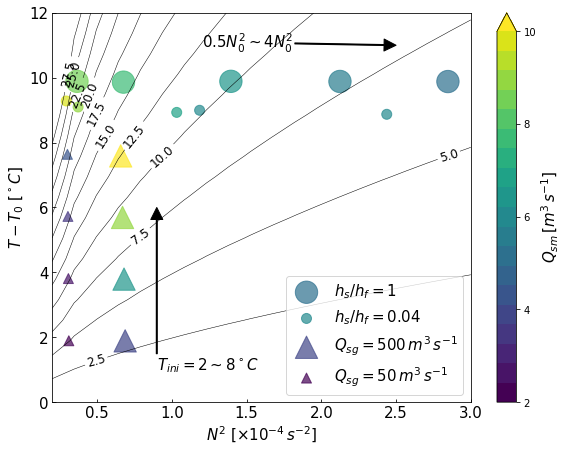

In [101]:
fig0, ax0 =plt.subplots(figsize=(8,6))
fig0.tight_layout() 

import matplotlib as mpl
cmap = mpl.cm.viridis
bounds = np.linspace(2,10,20)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

cqsm = np.arange(2.5,30,2.5)
cs = ax0.contour(Nsquare*1e4,TF,Qsm2/Qsg,cqsm,colors='k',linewidths=.5)
plt.clabel(cs, fmt='%1.1f', fontsize=12, inline=1)

# Marker size in units of points^2
volume1 = (10 * Qsm_ss / Qsm_ss[0])**2
volume2 = (10 * Qsm_ns / Qsm_ns[0])**2
volume3 = (10 * Qsm_maxq / Qsm_maxq[0])**2
volume4 = (10 * Qsm_minq / Qsm_minq[0])**2
volume = np.linspace(1,5,5)*15


Qsm = np.concatenate([Qsm_ss, Qsm_ns, Qsm_maxq[:-1], Qsm_minq[:-1]], axis=0)
min_, max_ = Qsm.min(), Qsm.max()

plt.scatter(N2_ns*1e4,T_ns,s=500, c=Qsm_ns, cmap=cmap, 
            norm=norm, alpha=0.7, label='$h_s/h_f=1$')
plt.clim(min_, max_)
plt.scatter(N2_mod*1e4,T_ss,s=100, c=Qsm_ss, cmap=cmap,
            norm=norm, alpha=0.7, label='$h_s/h_f=0.04$')
plt.clim(min_, max_)

plt.annotate('$0.5N^2_0\sim4N^2_0$', xy=(2.5,11), xytext=(1.2,10.9),
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)


plt.scatter(N2_maxq[:-1]*1e4,T_maxq[:-1],s=500, 
            c=Qsm_maxq[:-1], cmap=cmap,
            norm=norm, marker='^', 
            alpha=0.7, 
            label='$Q_{sg}=500\,m^3\,s^{-1}$')
plt.clim(min_, max_)

plt.scatter(N2_minq[:-1]*1e4,T_minq[:-1],s=100, 
            c=Qsm_minq[:-1], cmap=cmap,
            norm=norm, marker='^', 
            alpha=0.7, 
            label='$Q_{sg}=50\,m^3\,s^{-1}$')
plt.clim(min_, max_)

plt.annotate('$T_{ini}=2\sim8^\circ C$', xy=(.9,6), xytext=(.9,1),
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15)

plt.legend(loc='best', fontsize=15)



cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks([2,4,6,8,10])
cbar.set_label('$Q_{sm}\,[m^3\,s^{-1}]$', fontsize=15)
# cbaxes1 = fig0.add_axes([0.95, 0.5, 0.05, 0.5])
# cbar1 = fig0.colorbar(im1,cax=cbaxes1, orientation='vertical')
# cbar1.set_ticks([0, 4, 8, 12])
# cbar1.ax.set_title('$Q_{sm}$ [$m^3\,s^{-1}$]', size=15)
#ax0.set(xlim=(0, 3), ylim=(0, 12))
plt.tick_params(direction='in', labelsize=15)
#ax0.set_title('Filled Contour Plot')
plt.ylabel(r'$T-T_0$ [$^\circ C$]', size=15)
plt.xlabel(r'$N^2$ [$\times10^{-4}\,s^{-2}$]', size=15)


In [26]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig0.savefig(fig_path + 'Qsm_dependency.png', dpi=300, bbox_inches='tight')

In [14]:
np.linspace(1,5,5)

array([1., 2., 3., 4., 5.])